In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import warnings
warnings.filterwarnings(action='ignore')

import folium
KC_coord = (47.4081,-121.9949)
Seattle_coord = (47.6062,-122.3321)
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-notebook')
from yellowbrick.regressor import ResidualsPlot

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OrdinalEncoder, OneHotEncoder

In [2]:
# specify index_col=0 to avoid creating an "Unnamed: 0" column.
# specify parse date to avoid object dtype for dates
df = pd.read_csv('./data/kc_house_data.csv', index_col=0, parse_dates=['date']) 
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,NO,NONE,Average,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,NO,NONE,Average,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,NO,NONE,Average,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007


In [3]:
df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [4]:
df['bedrooms_bin']=pd.cut(df['bedrooms'], bins=[0,1,2,3,4,5,6,99], labels=['1_bed','2_bed','3_bed','4_bed','5_bed','6_bed','7+_bed'])

In [5]:
len(df)

21597

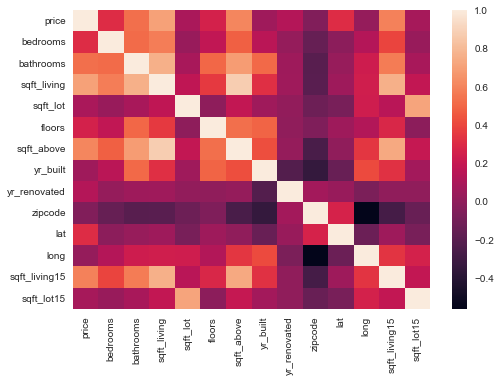

In [6]:
sns.heatmap(df.corr());

In [7]:
y = df['price']
X = df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)

# Helper Functions

ohe executes 2 transformations, test and train. data for any given input variable: First, we use OneHotEncoder to split up our categorical variables. Second, we run a linear regression on encoded values using .fit(). Then, it takes in a training df ('df'), a test df ('df2') and a column name. Next, it returns the training df and the test df concatenated with newly encoded columns. Lastly, we return a list of these newly encoded column names. 

In [8]:
def ohe(df, df2, column):
    for col in column:
        train = df[[col]]
        ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown="ignore")
        ohe.fit(train)
        encoded_train = ohe.transform(train)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_train = pd.DataFrame(encoded_train, columns=col_labels, index=df.index)
        df = pd.concat([df, encoded_train], axis=1)
        
        test = df2[[col]]
        encoded_test = ohe.transform(test)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_test = pd.DataFrame(encoded_test, columns=col_labels, index=df2.index)
        df2 = pd.concat([df2, encoded_test], axis=1)
        
    return df, df2, encoded_train.columns.tolist()

We run a Standard Scaler to scale all the values in the test data and training data so that our models results are in comparable units. Then, we score the scaled data to get the R2 to assess the strength of our model.

In [9]:
def scale_score(x, y, x2, y2):
    scaler = StandardScaler()
    scaler.fit(x)
    X_train_scaled = scaler.transform(x)
    X_test_scaled = scaler.transform(x2)

    lr = LinearRegression()
    lr.fit(X_train_scaled,y_train)

    train_preds = lr.predict(X_train_scaled)
    test_preds = lr.predict(X_test_scaled)
    
    print(f"""training score: {r2_score(y_train, train_preds)}
    test score: {r2_score(y_test, test_preds)}""")
    
    return X_train_scaled, X_test_scaled, train_preds, test_preds

Uses price and predictions to calculate Mean Absolute Error (MAE), Mean Squared Error (MSE) and Root Mean Squared Error (RSME) for the training and testing data sets. We will compare these values to evaluate model performance.

In [10]:
def get_train_test_metrics(y_train, train_preds,
               y_test, test_preds):
    """
    Prints different training and testing metrics, namely R2, MAE, MSE, RMSE
    """
    print("\nTraining Metrics:")
    print(f"R2: {r2_score(y_train, train_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    
    print("\nTesting Metrics:")
    print(f"R2: {r2_score(y_test, test_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

# Outliers

### Bedrooms

In [11]:
bedrooms_count = print(df['bedrooms'].value_counts())

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64


In [12]:
#drop the 33 bedroom outlier 
df = df[df['bedrooms'] != 33]
df = df[df['bedrooms'] != 11]
df = df[df['bedrooms'] != 10]
df = df[df['bedrooms'] != 9]
df = df[df['bedrooms'] != 8]
#df = df[df['bedrooms'] != 7]

### Price

In [13]:
# calculate 25, 75, iqr, whiskers for 'price'
price_q25, price_q75 = np.percentile(df['price'], [25, 75])
price_iqr = price_q75 - price_q25
price_min = price_q25 - (1.5 * price_iqr)
price_max = price_q75 + (1.5 * price_iqr)

print(f"""price_min: {price_min} 
price_max: {price_max}""")

price_min: -162625.0 
price_max: 1129575.0


In [14]:
df = df[df['price'] >= price_min]
df = df[df['price'] <= price_max]

### Sqft Lot

In [15]:
# calculate 25, 75, iqr, whiskers for 'sqft_lot'
sqft_lot_q25, sqft_lot_q75 = np.percentile(df['sqft_lot'], [25, 75])
sqft_lot_iqr = sqft_lot_q75 - sqft_lot_q25
sqft_lot_min = sqft_lot_q25 - (1.5 * sqft_lot_iqr)
sqft_lot_max = sqft_lot_q75 + (1.5 * sqft_lot_iqr)


print(f"""sqft_lot_min: {sqft_lot_min} 
sqft_lot_max: {sqft_lot_max}""")

sqft_lot_min: -2975.125 
sqft_lot_max: 18291.875


In [16]:
# set df to include everything within the whiskers except the outliers
df = df[df['sqft_lot'] >= sqft_lot_min]
df = df[df['sqft_lot'] <= sqft_lot_max]

### Grade

In [17]:
grade_count = print(df['grade'].value_counts())

7 Average        8358
8 Good           5294
6 Low Average    1872
9 Better         1866
10 Very Good      513
5 Fair            198
11 Excellent       75
4 Low              20
12 Luxury           1
3 Poor              1
Name: grade, dtype: int64


In [18]:
df = df[df['grade'] != '3 Poor']
df = df[df['grade'] != '12 Luxury']

# Train-Test Split

In [19]:
y = df['price']
X = df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)

# Categorical Variables

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18196 entries, 7129300520 to 1523300157
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           18196 non-null  datetime64[ns]
 1   price          18196 non-null  float64       
 2   bedrooms       18196 non-null  int64         
 3   bathrooms      18196 non-null  float64       
 4   sqft_living    18196 non-null  int64         
 5   sqft_lot       18196 non-null  int64         
 6   floors         18196 non-null  float64       
 7   waterfront     16149 non-null  object        
 8   view           18142 non-null  object        
 9   condition      18196 non-null  object        
 10  grade          18196 non-null  object        
 11  sqft_above     18196 non-null  int64         
 12  sqft_basement  18196 non-null  object        
 13  yr_built       18196 non-null  int64         
 14  yr_renovated   14952 non-null  float64       
 15  zipco

In [21]:
df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2047
view               54
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3244
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
bedrooms_bin        0
dtype: int64

In [22]:
#drop the 33 bedroom outlier 
df.drop(['date', 'yr_renovated', 'sqft_basement'], axis=1, inplace=True)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,bedrooms_bin
id,,,,,,,,,,,,,,,,,,
7129300520,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,1955,98178,47.5112,-122.257,1340,5650,3_bed
6414100192,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,1951,98125,47.7210,-122.319,1690,7639,3_bed
5631500400,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,1933,98028,47.7379,-122.233,2720,8062,2_bed
2487200875,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,1965,98136,47.5208,-122.393,1360,5000,4_bed
1954400510,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,1987,98074,47.6168,-122.045,1800,7503,3_bed


### Bedroom Bins

In [23]:
X_train, X_test, encoded_bedrooms_bins = ohe(X_train, X_test, ['bedrooms_bin'])

In [24]:
X_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,long,sqft_living15,sqft_lot15,bedrooms_bin,bedrooms_bin_x0_2_bed,bedrooms_bin_x0_3_bed,bedrooms_bin_x0_4_bed,bedrooms_bin_x0_5_bed,bedrooms_bin_x0_6_bed,bedrooms_bin_x0_7+_bed
id,,,,,,,,,,,,,,,,,,,,,
2138700345,2014-08-18,4,2.50,2430,6325,2.0,NO,NONE,Good,8 Good,...,-122.354,2340,4375,4_bed,0.0,0.0,1.0,0.0,0.0,0.0
546000910,2014-12-03,3,1.75,2040,4005,1.5,NO,NONE,Good,8 Good,...,-122.380,1380,4005,3_bed,0.0,1.0,0.0,0.0,0.0,0.0
5438000060,2014-11-03,3,2.25,1620,10850,1.0,NO,NONE,Average,7 Average,...,-122.194,1910,10568,3_bed,0.0,1.0,0.0,0.0,0.0,0.0
241900160,2015-03-10,5,2.50,2740,5460,2.0,NO,NONE,Average,8 Good,...,-122.204,2900,5971,5_bed,0.0,0.0,0.0,1.0,0.0,0.0
8898700960,2014-06-20,3,2.50,1820,8085,2.0,NO,NONE,Average,7 Average,...,-122.204,1860,8625,3_bed,0.0,1.0,0.0,0.0,0.0,0.0


### Condition

In [25]:
condition_count = df['condition'].value_counts()
condition_count

Average      11888
Good          4722
Very Good     1433
Fair           132
Poor            21
Name: condition, dtype: int64

In [26]:
X_train, X_test, encoded_condition = ohe(X_train, X_test, ['condition'])

In [27]:
X_train['condition'] = X_train['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

In [28]:
X_test['condition'] = X_test['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

### Grade

In [29]:
X_train, X_test, encoded_grade = ohe(X_train, X_test, ['grade'])

### View

In [30]:
X_train['view'].isna().sum()

43

In [31]:
view_count = df['view'].value_counts()
view_count

NONE         16854
AVERAGE        681
GOOD           257
FAIR           246
EXCELLENT      104
Name: view, dtype: int64

In [32]:
X_train['view'].fillna('NONE', inplace=True)
X_test['view'].fillna('NONE', inplace=True)

In [33]:
X_train, X_test, encoded_view = ohe(X_train, X_test, ['view'])

In [34]:
X_train['view'] = X_train['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

In [35]:
X_test['view'] = X_test['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

### Waterfront

In [36]:
X_train['waterfront'].fillna('NO', inplace=True)
X_test['waterfront'].fillna('NO', inplace=True)

In [37]:
waterfront_train = X_train[['waterfront']]

encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_train)
encoder_waterfront.categories_[0]

waterfront_encoded_train = encoder_waterfront.transform(waterfront_train)
waterfront_encoded_train = waterfront_encoded_train.flatten()

X_train['waterfront'] = waterfront_encoded_train

In [38]:
waterfront_test = X_test[['waterfront']]

encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_test)
encoder_waterfront.categories_[0]

waterfront_encoded_test = encoder_waterfront.transform(waterfront_test)
waterfront_encoded_test = waterfront_encoded_train.flatten()

X_train['waterfront'] = waterfront_encoded_test

### Zipcode

In [39]:
X_train, X_test, encoded_zipcode = ohe(X_train, X_test, ['zipcode'])

# Models

In [40]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
basemodel_dummy_score = dummy.score(X_train, y_train)
test_dummy_score = dummy.score(X_test, y_test)

print(f"""basemodel_dummy_score: {basemodel_dummy_score}

test_dummy_score: {test_dummy_score}""")

basemodel_dummy_score: 0.0

test_dummy_score: -8.176425275485677e-05


In [41]:
df.corr()['price'].abs().sort_values(ascending=False)

price            1.000000
sqft_living      0.599248
sqft_living15    0.536819
sqft_above       0.492819
lat              0.449995
bathrooms        0.429848
bedrooms         0.293951
floors           0.262830
long             0.035106
yr_built         0.025220
sqft_lot15       0.024246
sqft_lot         0.004952
zipcode          0.003088
Name: price, dtype: float64

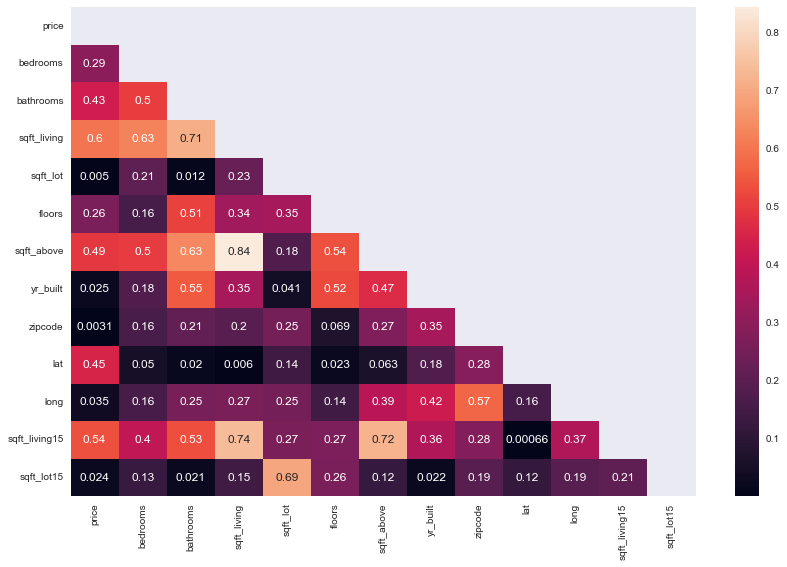

In [42]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(14, 9))
    
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    ax = sns.heatmap(abs(df.corr()),mask=mask,annot=True)
    fig.savefig('images/Corelation_Heatmap_15',bbox_inches="tight")

### Model 1

In [43]:
cols = ['sqft_living']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [44]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.3656818850149134
    test score: 0.3389745465643611


In [45]:
y_sqft_liv = df['price']
X_sqft_liv = df[['sqft_living']]

model = sm.OLS(y_sqft_liv, sm.add_constant(X_sqft_liv)).fit()
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                 1.019e+04
Date:                Tue, 02 Aug 2022   Prob (F-statistic):               0.00
Time:                        07:30:53   Log-Likelihood:            -2.4424e+05
No. Observations:               18196   AIC:                         4.885e+05
Df Residuals:                   18194   BIC:                         4.885e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.449e+05   3408.463     42.515      0.000    1.38e+05    1.52e+05
sqft_living   168.5510      1.669    100.966      0.000     165.279     171.823
==============================================================================
Omnibus:                      824.421   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              939.234
Skew:                           0.550   Prob(JB):                    1.12e-204
Kurtosis:                       3.172   Cond. No.                     5.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model 2

In [46]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15'] + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [47]:
X_train_scaled, X_test_scaled, train_preds, test_preds=scale_score(x, y, x2, y2)

training score: 0.8048014639575377
    test score: 0.7878857152972278


In [48]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.805
Mean Absolute Error: 66074.158
Mean Squared Error: 8138259254.547
Root Mean Squared Error: 90212.301

Testing Metrics:
R2: 0.788
Mean Absolute Error: 68414.852
Mean Squared Error: 8809338179.851
Root Mean Squared Error: 93858.075


### Model 2b

In [49]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'zipcode']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [50]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.4083055782153089
    test score: 0.3840940989715631


In [51]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.408
Mean Absolute Error: 126254.886
Mean Squared Error: 24669050811.456
Root Mean Squared Error: 157063.843

Testing Metrics:
R2: 0.384
Mean Absolute Error: 128178.975
Mean Squared Error: 25579245531.379
Root Mean Squared Error: 159935.129


### Model 3

In [52]:
cols = ['bedrooms', 'sqft_living', 'sqft_living15']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [53]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.391781681115435
    test score: 0.3677724867806368


In [54]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.392
Mean Absolute Error: 127981.684
Mean Squared Error: 25357968675.394
Root Mean Squared Error: 159241.856

Testing Metrics:
R2: 0.368
Mean Absolute Error: 130030.958
Mean Squared Error: 26257099932.518
Root Mean Squared Error: 162040.427


### Model 3b

In [55]:
cols = ['sqft_living', 'sqft_living15'] + encoded_bedrooms_bins + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [56]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.8061655853130828
    test score: 0.7911318216202153


In [57]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.806
Mean Absolute Error: 65797.946
Mean Squared Error: 8081386014.250
Root Mean Squared Error: 89896.529

Testing Metrics:
R2: 0.791
Mean Absolute Error: 67823.982
Mean Squared Error: 8674523834.805
Root Mean Squared Error: 93137.124


### Model 4

In [58]:
cols = ['bedrooms', 'sqft_living'] + encoded_condition + encoded_zipcode 

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [59]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7953825572320556
    test score: 0.7825186094440924


In [60]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.795
Mean Absolute Error: 67204.065
Mean Squared Error: 8530954335.056
Root Mean Squared Error: 92363.165

Testing Metrics:
R2: 0.783
Mean Absolute Error: 69019.682
Mean Squared Error: 9032239954.588
Root Mean Squared Error: 95038.097


### Model 4b

In [61]:
cols = ['sqft_living'] + encoded_bedrooms_bins + encoded_condition + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [62]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7965835331972433
    test score: 0.7851945970315641


In [63]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.797
Mean Absolute Error: 67025.435
Mean Squared Error: 8480882987.384
Root Mean Squared Error: 92091.710

Testing Metrics:
R2: 0.785
Mean Absolute Error: 68527.570
Mean Squared Error: 8921103264.024
Root Mean Squared Error: 94451.592


### Model 5

In [64]:
cols = ['bathrooms', 'bedrooms', 'condition', 'sqft_living', 'view'] + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [65]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.8103272472030093
    test score: 0.7941991185111233


In [66]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.810
Mean Absolute Error: 65350.598
Mean Squared Error: 7907877113.637
Root Mean Squared Error: 88926.245

Testing Metrics:
R2: 0.794
Mean Absolute Error: 67361.087
Mean Squared Error: 8547135640.993
Root Mean Squared Error: 92450.720


### Model 5b

In [67]:
cols = ['bathrooms', 'sqft_living'] + encoded_bedrooms_bins + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [68]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.8130679766787744
    test score: 0.7983137463538114


In [69]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.813
Mean Absolute Error: 64869.876
Mean Squared Error: 7793610032.169
Root Mean Squared Error: 88281.425

Testing Metrics:
R2: 0.798
Mean Absolute Error: 66646.894
Mean Squared Error: 8376250647.551
Root Mean Squared Error: 91521.859


### Model 6

In [70]:
cols = ['bathrooms', 'bedrooms', 'sqft_living', 'yr_built'] + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [71]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.8119405646490111
    test score: 0.7959817252476837


In [72]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.812
Mean Absolute Error: 65088.381
Mean Squared Error: 7840614336.458
Root Mean Squared Error: 88547.244

Testing Metrics:
R2: 0.796
Mean Absolute Error: 67090.054
Mean Squared Error: 8473102034.034
Root Mean Squared Error: 92049.454


### Model 6b

In [73]:
cols = ['bathrooms', 'sqft_living', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [74]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.8133307289129226
    test score: 0.7987899488537036


In [75]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.813
Mean Absolute Error: 64839.645
Mean Squared Error: 7782655309.636
Root Mean Squared Error: 88219.359

Testing Metrics:
R2: 0.799
Mean Absolute Error: 66594.451
Mean Squared Error: 8356473437.027
Root Mean Squared Error: 91413.749


### Model 7

In [76]:
cols = ['bathrooms', 'bedrooms', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [77]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.8218412256260551
    test score: 0.8057098594859072


In [78]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.822
Mean Absolute Error: 63344.504
Mean Squared Error: 7427833854.308
Root Mean Squared Error: 86184.882

Testing Metrics:
R2: 0.806
Mean Absolute Error: 65474.323
Mean Squared Error: 8069081981.903
Root Mean Squared Error: 89828.069


### Model 7b

In [79]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [80]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.8229258080534677
    test score: 0.8079838545863838


In [81]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.823
Mean Absolute Error: 63098.466
Mean Squared Error: 7382615210.991
Root Mean Squared Error: 85922.146

Testing Metrics:
R2: 0.808
Mean Absolute Error: 64985.907
Mean Squared Error: 7974640478.882
Root Mean Squared Error: 89300.843


### Model 8

In [82]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [83]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.811445692162305
    test score: 0.799639116016319


In [84]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.811
Mean Absolute Error: 64764.518
Mean Squared Error: 7861246666.374
Root Mean Squared Error: 88663.672

Testing Metrics:
R2: 0.800
Mean Absolute Error: 66439.571
Mean Squared Error: 8321206596.243
Root Mean Squared Error: 91220.648


### Model 9

In [85]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [86]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.8427557845184872
    test score: 0.829833425695553


In [87]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.843
Mean Absolute Error: 59550.936
Mean Squared Error: 6555859576.673
Root Mean Squared Error: 80968.263

Testing Metrics:
R2: 0.830
Mean Absolute Error: 61079.370
Mean Squared Error: 7067203899.328
Root Mean Squared Error: 84066.663


### Model 10

In [88]:
cols = ['sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [89]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.8221715422219785
    test score: 0.8072327523358692


In [90]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.822
Mean Absolute Error: 63218.396
Mean Squared Error: 7414062223.904
Root Mean Squared Error: 86104.949

Testing Metrics:
R2: 0.807
Mean Absolute Error: 65081.642
Mean Squared Error: 8005834576.638
Root Mean Squared Error: 89475.329


### Model 11

In [91]:
cols = ['sqft_living'] + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [92]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7911467044809202
    test score: 0.7746396415570765


In [93]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.791
Mean Absolute Error: 67977.351
Mean Squared Error: 8707556416.976
Root Mean Squared Error: 93314.288

Testing Metrics:
R2: 0.775
Mean Absolute Error: 70158.525
Mean Squared Error: 9359462106.185
Root Mean Squared Error: 96744.313
